## Задание 1
### 1.1
$MSE = \frac{1}{n}\sum(y_i - \hat{y_i})^2$, где $y_i$ - реальное значение, а $\hat{y_i}$ - предсказанное.
В дальнейшем будем считать, что $\hat{y_{i,1}}$ - выбор среднего значения по таргету, а $\hat{y_{i,2}}$ - выбор случайного объекта из таргета.
Распишем матожидание MSE: $E\frac{1}{n}\sum(y_i - \hat{y_i}) = \frac{1}{n}\sum E(y_i - \hat{y_i})^2 = \frac{1}{n}\sum (y_i^2 - 2 y_i E\hat{y_i} + E\hat{y_i^2})$
Таким образом, нам надо сравнить первый и второй момент у вторых стратегий.
Первый момент: $E\hat{y_{i,2}} = \frac{1}{n}\sum y_i = M = E\hat{y_{i,1}}$, где $M$ - среднее значение.
Второй момент: $E\hat{y_{i,2}}^2 = \frac{1}{n}\sum y_i^2 \leq M^2 = E\hat{y_{i,1}}^2$, неравенство следует из положительности дисперсии. Таким образом, стратегия "выдавать среднее значение по таргету" более выгодна с точки зрения MSE.

## Задание 2

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
import pandas as pd
import pydotplus 
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
%matplotlib inline

Считаем тестовые данные. Я использовала файл, в котором все признаки количественные.

In [9]:
a = 1000
fin = file('german.data-numeric.txt', 'r')
X, y= [], []
for i in range(1000):
    data = [int(j) for j in fin.readline().strip().split()]
    X.append(data[:-1])
    y.append(data[-1])
X = np.array(X)
y = np.array(y)
fin.close()

Посмотрим по кросс-валидации, для какой глубины достигается наилучшее качество.

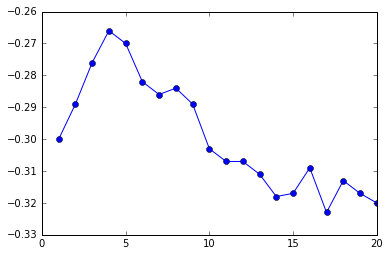

In [4]:
plot_y = []
for i in range(1, 21):
    plot_y.append(np.mean(cross_val_score(DecisionTreeClassifier(max_depth=i), X, y, cv=5, scoring='neg_mean_squared_error')))
plt.plot(range(1,21), plot_y, '-ob')

Видим, что наилучшее качество достигается на глубине 4.

Теперь проверим то же самое по тестовой выборке.

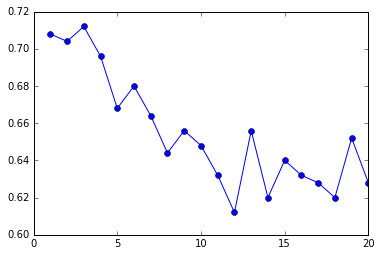

In [10]:
plot_y = []
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.25)
for i in range(1, 21):
    tr = tree.DecisionTreeClassifier(max_depth=i)
    tr.fit(train_data, train_target)
    test_predictions = tr.predict(test_data)
    plot_y.append(accuracy_score(test_target, test_predictions))
plt.plot(range(1,21), plot_y, '-ob')

Тут лучшее качество достигается на глубине 3.
Попробуем визуализировать деревья на глубине 3 и 4.

In [60]:
model1 = tree.DecisionTreeClassifier(max_depth=3)
model1.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

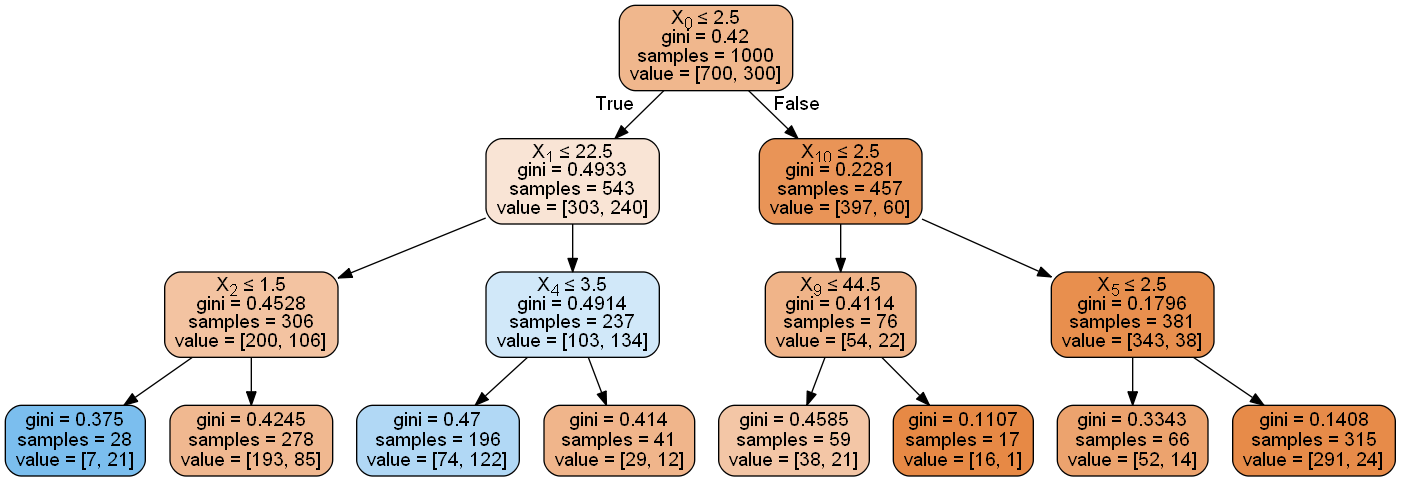

In [62]:
dot_data = tree.export_graphviz(model1, out_file="tree1.out", 
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file("tree1.out")  
Image(graph.create_png())

In [65]:
model2 = tree.DecisionTreeClassifier(max_depth=4)
model2.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

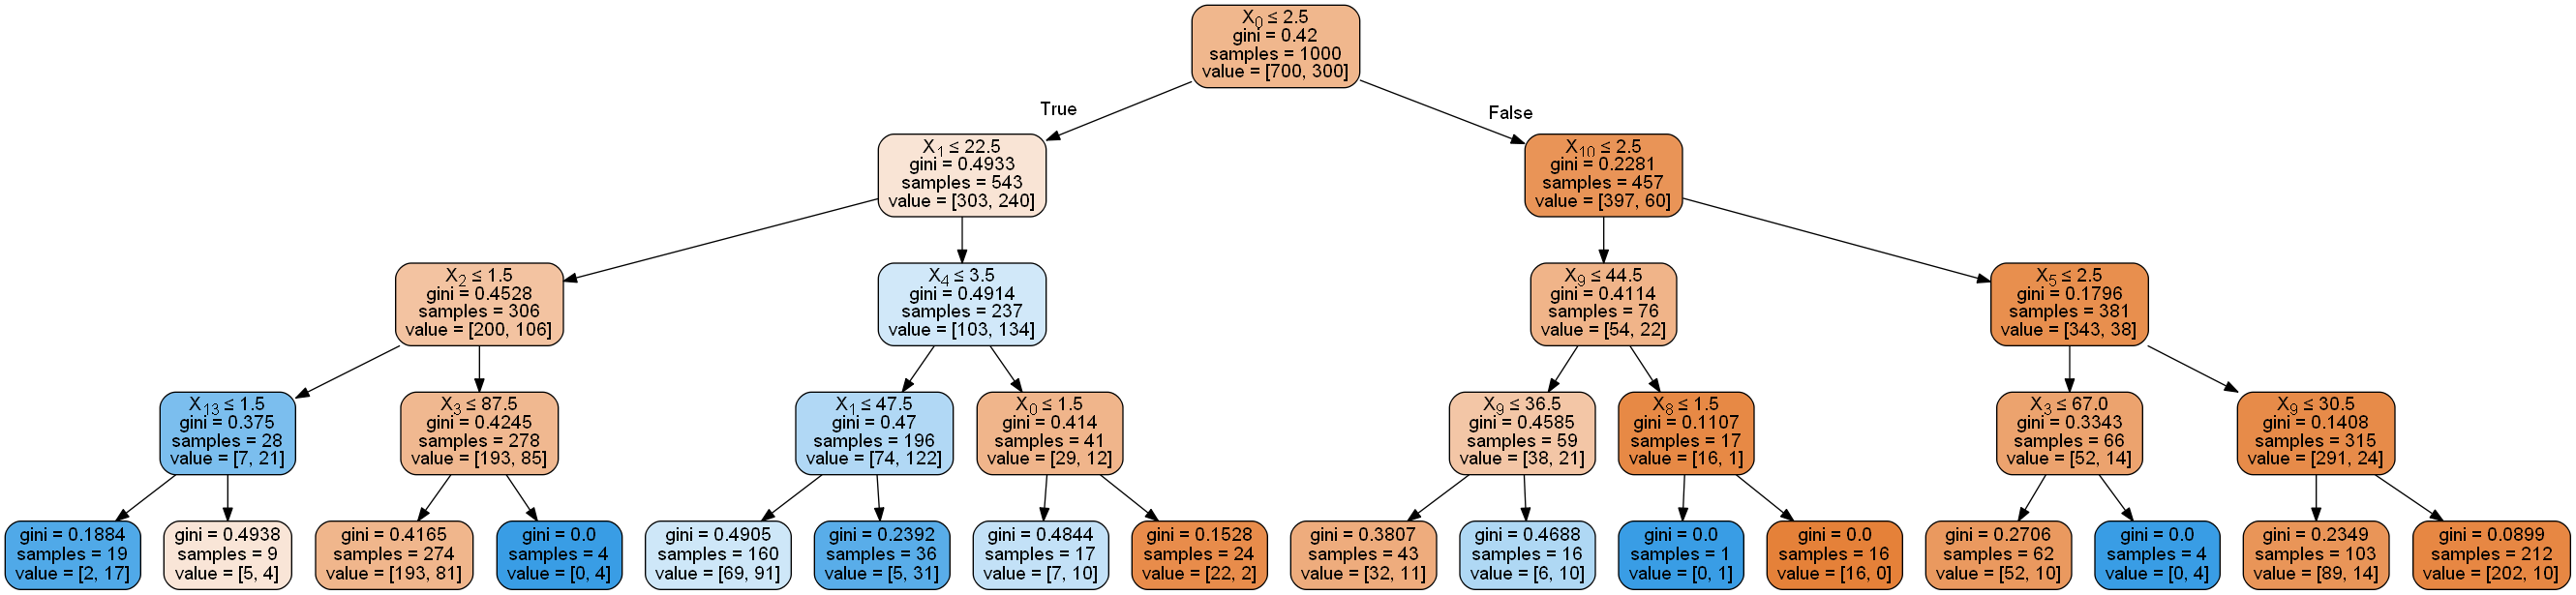

In [66]:
dot_data = tree.export_graphviz(model2, out_file="tree2.out", 
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file("tree2.out")  
Image(graph.create_png())

Видим, что первое разделение происходит по количеству денег на счету. Причём, если денег много, то мы скорее дадим этому человеку кредит.
Видим, что хорошая ситуация для кандидата на кредит - если у него много денег на счету, он работатет долгое время, и это человек средних лет.

## Задание 3

In [67]:
from sklearn.datasets import load_boston
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

In [173]:
class DecisionTree(BaseEstimator):
    def __init__(self, max_depth=6):
        self.max_depth = max_depth
    
    def fit(self, X, y):
        self.root = DecisionTree.Node(X, y, self.max_depth)
    
    def predict(self, X):
        y = []
        for x in X:
            cur_depth = 0
            cur_node = self.root
            while not cur_node.is_leaf:
                cur_depth += 1
                if x[cur_node.feature] <= cur_node.bound:
                    cur_node = cur_node.left
                else:
                    cur_node = cur_node.right
            y.append(cur_node.result)
        return y
    
    class Node():
        def __init__(self, X, y, max_depth):
           # print 'NEW NODE'
            self.max_depth = max_depth
            self.X = X
            self.y = y
            self.split()
            
        def partition_error(self, sorted_feature, bound, ft):
            Q = len(sorted_feature)
            R = len(sorted_feature[:bound])
            L = len(sorted_feature[(bound+1):])
            if R == 0 or L == 0:
                return np.inf
            
            h_left, h_right = [], []
            for i in range(len(self.X)):
                if self.X[i, ft] <= sorted_feature[bound]:
                    h_left.append(self.y[i])
                else:
                    h_right.append(self.y[i])
            if not h_left or not h_right:
                return np.inf
            else:
                r, l = len(h_right), len(h_left)
                rm, lm = sum(h_right)/r, sum(h_left)/l
                h_right = sum((np.array(h_right) - rm)**2)/r
                h_left = sum((np.array(h_left) - lm)**2)/l
            
            
            return float(R)/Q * h_right + float(L)/Q * h_left
        
        def split(self):
            if len(self.y) == 1 or self.max_depth == 1:
                self.is_leaf = True
                self.result = np.mean(self.y)
                return
            self.is_leaf = False
            for i in range(len(self.X[0])):
                sorted_feature = np.sort(list(set(self.X[:,i])))
                if len(sorted_feature) <= 1:
                    continue
                self.split_err = np.inf
                for bound in range(1, len(sorted_feature) - 1):
                    err = self.partition_error(sorted_feature, bound, i)
                    if err < self.split_err:
                      #  print err
                        self.split_err = err
                        self.feature = i
                        self.bound = sorted_feature[bound]
               # print 'bound', self.bound

            X_left, X_right, y_left, y_right = [], [], [], []
            for i in range(len(self.X)):
                if self.X[i][self.feature] > self.bound:
                    X_right.append(self.X[i])
                    y_right.append(self.y[i])
                else:
                    X_left.append(self.X[i])
                    y_left.append(self.y[i])
           # print X_right
            self.left = DecisionTree.Node(np.array(X_left), y_left, self.max_depth - 1)
            self.right = DecisionTree.Node(np.array(X_right), y_right, self.max_depth - 1)
                    
                
                


In [174]:
data = load_boston()
X = data['data']
y = data['target']

In [176]:
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.75)
model = DecisionTree()
model.fit(train_data, train_target)
test_predictions = model.predict(test_data)
mean_squared_error(test_predictions, test_target)
#accuracy_score(test_target, test_predictions)

82.476178282688494